In [1]:
import sys
import os
import json
from pathlib import Path

import pandas as pd

In [2]:
root_dir = Path.cwd().parent

In [3]:
sys.path.append(str(root_dir))

In [4]:
from src.extractor.pos_extractor import PosExtractor
from src.metrics.rouge_like import mean_rouge_like_metric

/Users/user/anaconda3/envs/poetry_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
val = pd.read_csv(root_dir / "data" / "val.csv")
val.head()

,text,target_spacy,target_gpt_3.5
0,Man in apron standing on front of oven with pa...,"{""objects"": {""Man"": [], ""apron"": [], ""front"": ...","{""objects"": {""man"": [""apron""], ""oven"": [], ""pa..."
1,A small kitchen has various appliances and a t...,"{""objects"": {""kitchen"": [""small""], ""appliances...","{""objects"": {""kitchen"": [""small""], ""appliances..."
2,The kitchen is clean and ready for us to see.,"{""objects"": {""kitchen"": []}}","{""objects"": {""kitchen"": [""clean""], ""us"": []}}"
3,a homeless man holding a cup and standing next...,"{""objects"": {""man"": [""homeless""], ""cup"": [], ""...","{""objects"": {""man"": [""homeless""], ""cup"": [], ""..."
4,a blue bike parked on a side walk,"{""objects"": {""bike"": [""blue""], ""side"": [], ""wa...","{""objects"": {""bike"": [""blue""], ""side walk"": []}}"


In [48]:
gpt_4o_target = pd.read_csv(root_dir/ "data" / "labels_val_gpt_4o.csv", sep="~")

In [50]:
val = val.merge(gpt_4o_target, on="text", how="left")

In [62]:
val.head()

,text,target_spacy,target_gpt_3.5,target_gpt_4o
0,Man in apron standing on front of oven with pa...,"{""objects"": {""Man"": [], ""apron"": [], ""front"": ...","{""objects"": {""man"": [""apron""], ""oven"": [], ""pa...","{""objects"": {""man"": [], ""apron"": [], ""oven"": [..."
1,A small kitchen has various appliances and a t...,"{""objects"": {""kitchen"": [""small""], ""appliances...","{""objects"": {""kitchen"": [""small""], ""appliances...","{""objects"": {""kitchen"": [""small""], ""appliances..."
2,The kitchen is clean and ready for us to see.,"{""objects"": {""kitchen"": []}}","{""objects"": {""kitchen"": [""clean""], ""us"": []}}","{""objects"": {""kitchen"": [""clean""]}}"
3,a homeless man holding a cup and standing next...,"{""objects"": {""man"": [""homeless""], ""cup"": [], ""...","{""objects"": {""man"": [""homeless""], ""cup"": [], ""...","{""objects"": {""man"": [""homeless""], ""cup"": [], ""..."
4,a blue bike parked on a side walk,"{""objects"": {""bike"": [""blue""], ""side"": [], ""wa...","{""objects"": {""bike"": [""blue""], ""side walk"": []}}",NaN


### POS extractor:

#### spacy target:

In [6]:
extractor = PosExtractor()
val["pos_pred"] = val["text"].apply(extractor.extract)
val.head()

,text,target_spacy,target_gpt_3.5,pos_pred
0,Man in apron standing on front of oven with pa...,"{""objects"": {""Man"": [], ""apron"": [], ""front"": ...","{""objects"": {""man"": [""apron""], ""oven"": [], ""pa...","{'objects': {'man': [], 'front': [], 'pans': [..."
1,A small kitchen has various appliances and a t...,"{""objects"": {""kitchen"": [""small""], ""appliances...","{""objects"": {""kitchen"": [""small""], ""appliances...","{'objects': {'table': [], 'kitchen': ['small']..."
2,The kitchen is clean and ready for us to see.,"{""objects"": {""kitchen"": []}}","{""objects"": {""kitchen"": [""clean""], ""us"": []}}","{'objects': {'kitchen': ['clean', 'ready']}}"
3,a homeless man holding a cup and standing next...,"{""objects"": {""man"": [""homeless""], ""cup"": [], ""...","{""objects"": {""man"": [""homeless""], ""cup"": [], ""...","{'objects': {'cup': [], 'shopping': [], 'cart'..."
4,a blue bike parked on a side walk,"{""objects"": {""bike"": [""blue""], ""side"": [], ""wa...","{""objects"": {""bike"": [""blue""], ""side walk"": []}}","{'objects': {'side': [], 'walk': [], 'bike': [..."


In [10]:
pred = val["pos_pred"]
target = val["target_spacy"].apply(json.loads)

metric = mean_rouge_like_metric(pred_col=pred, target_col=target)
print(f"{metric=:.3f}")

metric_with_penalty = mean_rouge_like_metric(pred_col=pred, target_col=target, penalty=True)
print(f"{metric_with_penalty=:.3f}")

metric=0.932
metric_with_penalty=0.930


#### gpt-3.5 target

In [22]:
print(len(val))
val = val[val["target_gpt_3.5"].apply(json.loads) != {"objects": {}}]
print(len(val))

12697
12694


In [23]:
pred = val["pos_pred"]
target = val["target_gpt_3.5"].apply(json.loads)

metric = mean_rouge_like_metric(pred_col=pred, target_col=target)
print(f"{metric=:.3f}")

metric_with_penalty = mean_rouge_like_metric(pred_col=pred, target_col=target, penalty=True)
print(f"{metric_with_penalty=:.3f}")

metric=0.687
metric_with_penalty=0.108


#### gpt-4o target

In [55]:
extractor = PosExtractor()
pred = val.loc[val["target_gpt_4o"].notna(), "text"].apply(extractor.extract)
target = val.loc[val["target_gpt_4o"].notna(), "target_gpt_4o"].apply(json.loads)

metric = mean_rouge_like_metric(pred_col=pred, target_col=target)
print(f"{metric=:.3f}")

metric_with_penalty = mean_rouge_like_metric(pred_col=pred, target_col=target, penalty=True)
print(f"{metric_with_penalty=:.3f}")

metric=0.850
metric_with_penalty=0.521


### BERT extractor: average first 6 attention layers

#### spacy target:

In [56]:
from src.extractor import BertExtractor
from src.core.settings import BertExtractorSettings

In [57]:
extractor = BertExtractor(BertExtractorSettings.from_yaml(root_dir / "configs" / "bert_extractor_settings.yaml"))
extractor.config

/Users/user/anaconda3/envs/poetry_env/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

BertExtractorSettings(pretrained_model_name='google-bert/bert-base-uncased', process_attentions=<ProcessAttentions.get_all_mean: 'get_all_mean'>, n_blocks_to_average=6)

In [93]:
pred = val["text"].apply(extractor.extract)
target = val["target_spacy"].apply(json.loads)

metric = mean_rouge_like_metric(pred_col=pred, target_col=target)
print(f"{metric=:.3f}")

metric_with_penalty = mean_rouge_like_metric(pred_col=pred, target_col=target, penalty=True)
print(f"{metric_with_penalty=:.3f}")

metric=0.995
metric_with_penalty=0.991


In [97]:
val.loc[0, "text"]

'Man in apron standing on front of oven with pans and bakeware'

In [98]:
pred[0]

{'objects': {'bakeware': [],
  'pans': [],
  'front': [],
  'man': [],
  'apron': [],
  'oven': []}}

In [99]:
val["target_gpt_3.5"].apply(json.loads)[0]

{'objects': {'man': ['apron'], 'oven': [], 'pans': [], 'bakeware': []}}

#### gpt-3.5 target

In [9]:
val = val[val["target_gpt_3.5"].apply(json.loads) != {"objects": {}}]

target = val["target_gpt_3.5"].apply(json.loads)

metric = mean_rouge_like_metric(pred_col=pred, target_col=target)
print(f"{metric=:.3f}")

metric_with_penalty = mean_rouge_like_metric(pred_col=pred, target_col=target, penalty=True)
print(f"{metric_with_penalty=:.3f}")

metric=0.227
metric_with_penalty=-0.965


#### gpt-4o target

In [58]:
pred = val.loc[val["target_gpt_4o"].notna(), "text"].apply(extractor.extract)
target = val.loc[val["target_gpt_4o"].notna(), "target_gpt_4o"].apply(json.loads)

metric = mean_rouge_like_metric(pred_col=pred, target_col=target)
print(f"{metric=:.3f}")

metric_with_penalty = mean_rouge_like_metric(pred_col=pred, target_col=target, penalty=True)
print(f"{metric_with_penalty=:.3f}")

metric=0.911
metric_with_penalty=0.544


### BERT extractor: first attention layer

In [60]:
config = BertExtractorSettings(process_attentions="get_first")
extractor = BertExtractor(config)

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
pred = val["text"].apply(extractor.extract)
target = val["target_spacy"].apply(json.loads)

metric = mean_rouge_like_metric(pred_col=pred, target_col=target)
print(f"{metric=:.3f}")

metric_with_penalty = mean_rouge_like_metric(pred_col=pred, target_col=target, penalty=True)
print(f"{metric_with_penalty=:.3f}")

metric=0.995
metric_with_penalty=0.991


#### gpt-4o target

In [61]:
pred = val.loc[val["target_gpt_4o"].notna(), "text"].apply(extractor.extract)
target = val.loc[val["target_gpt_4o"].notna(), "target_gpt_4o"].apply(json.loads)

metric = mean_rouge_like_metric(pred_col=pred, target_col=target)
print(f"{metric=:.3f}")

metric_with_penalty = mean_rouge_like_metric(pred_col=pred, target_col=target, penalty=True)
print(f"{metric_with_penalty=:.3f}")

metric=0.911
metric_with_penalty=0.545


### Bert Extractor: attentions visualization

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt


def dict_to_df(attentions_dict: dict[str, float]) -> pd.DataFrame:
    return pd.DataFrame(
        {"noun": attentions_dict.keys(), "attention_weight": attentions_dict.values()}
    )


def visualize_attentions_dict(attentions_dict: dict[str, dict[str, float]], adj: str):
    assert adj in attentions_dict, "adjective not in attentions dict"
    df = dict_to_df(attentions_dict[adj])

    bar_plot = sns.barplot(x="noun", y="attention_weight", data=df, palette="viridis", hue="noun")  # 'viridis' is a color palette, you can choose any
    plt.title(f"adjective = {adj}")
    plt.xlabel("Noun")
    plt.ylabel("Attention weight")
    plt.show()

In [73]:
text = val.loc[1, "text"]
text

'A small kitchen has various appliances and a table.'

In [74]:
attentions_dict = extractor.get_adjectives_attentions(text)

In [75]:
sorted(attentions_dict["small"].items(), key=lambda x: -x[1])

[('kitchen', 0.17516539990901947),
 ('appliances', 0.12372007220983505),
 ('table', 0.0816829726099968)]

In [76]:
sorted(attentions_dict["various"].items(), key=lambda x: -x[1])

[('appliances', 0.17663581669330597),
 ('kitchen', 0.13920210301876068),
 ('table', 0.06601058691740036)]

#### avg blocks

In [63]:
text = "the weather was terrible but we had great time playing video games"
attentions_dict = extractor.get_adjectives_attentions(text)

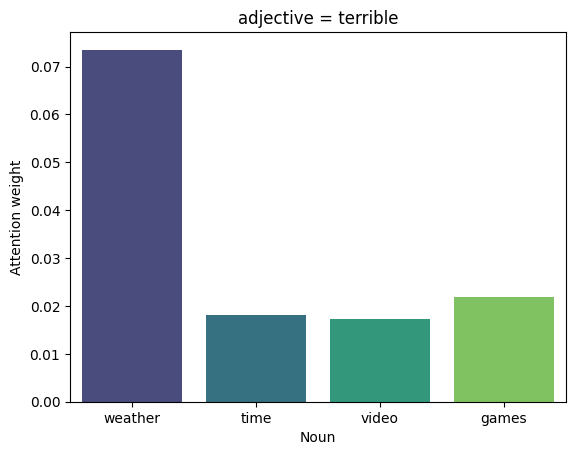

In [65]:
visualize_attentions_dict(attentions_dict, "terrible")

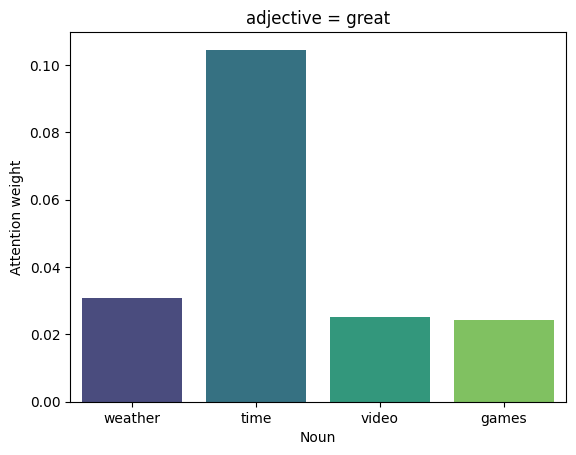

In [66]:
visualize_attentions_dict(attentions_dict, "great")

#### first block

In [77]:
text = "the weather was terrible but we had great time playing video games"
attentions_dict = extractor.get_adjectives_attentions(text)

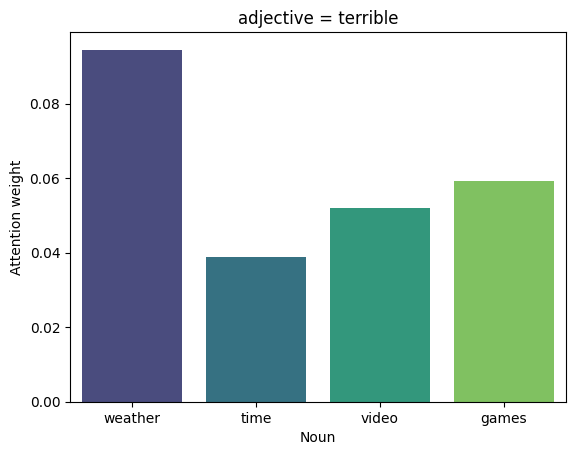

In [78]:
visualize_attentions_dict(attentions_dict, "terrible")

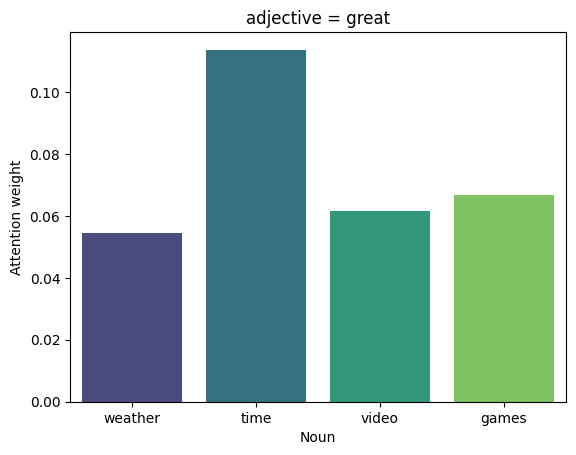

In [79]:
visualize_attentions_dict(attentions_dict, "great")

In [83]:
extractor = BertExtractor(BertExtractorSettings.from_yaml(root_dir / "configs" / "bert_extractor_settings.yaml"))

/Users/user/anaconda3/envs/poetry_env/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificatio

In [89]:
extractor.config

BertExtractorSettings(pretrained_model_name='google-bert/bert-base-uncased', process_attentions=<ProcessAttentions.get_all_mean: 'get_all_mean'>, n_blocks_to_average=6)

#### avg blocks

In [86]:
text = "the weather was terrible but we had great time playing video games"
attentions_dict = extractor.get_adjectives_attentions(text)

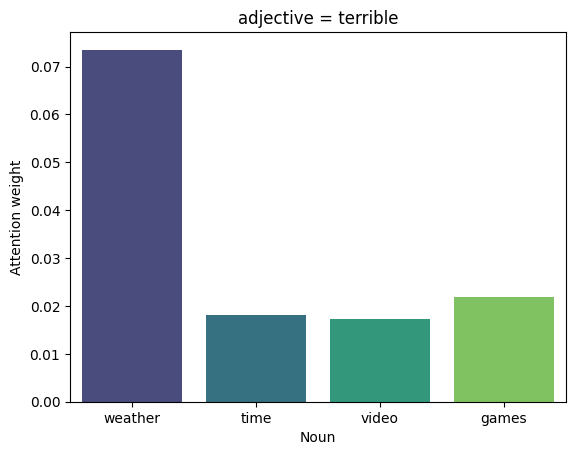

In [87]:
visualize_attentions_dict(attentions_dict, "terrible")

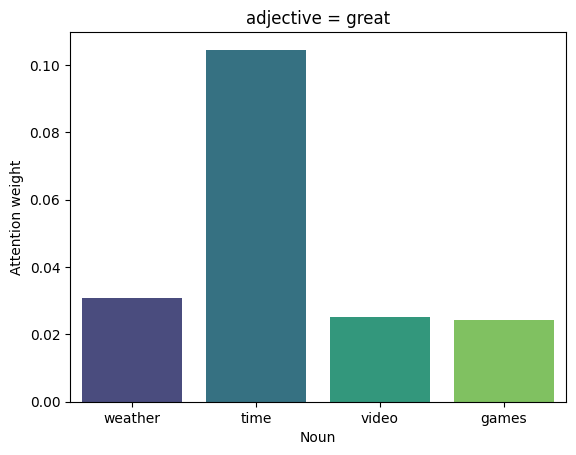

In [88]:
visualize_attentions_dict(attentions_dict, "great")

### LLM extractor

#### gpt-3.5

In [31]:
target = val["target_spacy"].apply(json.loads)

pred = val["target_gpt_3.5"].apply(json.loads)
metric = mean_rouge_like_metric(pred_col=pred, target_col=target)
print(f"{metric=:.3f}")

metric_with_penalty = mean_rouge_like_metric(pred_col=pred, target_col=target, penalty=True)
print(f"{metric_with_penalty=:.3f}")

metric=0.599
metric_with_penalty=0.451


#### gpt-4o

In [64]:
target = val.loc[val["target_gpt_4o"].notna(), "target_spacy"].apply(json.loads)
pred = val.loc[val["target_gpt_4o"].notna(), "target_gpt_4o"].apply(json.loads)

metric = mean_rouge_like_metric(pred_col=pred, target_col=target)
print(f"{metric=:.3f}")

metric_with_penalty = mean_rouge_like_metric(pred_col=pred, target_col=target, penalty=True)
print(f"{metric_with_penalty=:.3f}")

metric=0.718
metric_with_penalty=0.665


### ChatGPT-4o target

In [36]:
gpt_4o_target = pd.read_csv(root_dir/ "data" / "labels_val_gpt_4o.csv", sep="~")

In [42]:
gpt_4o_target = gpt_4o_target.merge(val, on="text", how="inner")[["text", "target_gpt_4o"]]

In [43]:
gpt_4o_target

,text,target_gpt_4o
0,Several jets that are flying in the air perfor...,"{""objects"": {""jets"": [""several""], ""air"": []}}"
1,A sky view of several planes flying in formati...,"{""objects"": {""planes"": [""several""], ""sky"": []}}"
2,An airplane is letting off white smoke against...,"{""objects"": {""airplane"": [], ""smoke"": [""white""..."
3,A biplane flying upside down leaving a large v...,"{""objects"": {""biplane"": [], ""vapor trail"": [""l..."
4,a white and red plane parked on a tarmac,"{""objects"": {""plane"": [""white"", ""red""], ""tarma..."
...,...,...
1020,A guy rides his skate board on the city sidewa...,"{""objects"": {""guy"": [], ""skateboard"": [], ""sid..."
1021,there is a man wearing a plad shirt riding a s...,"{""objects"": {""man"": [], ""shirt"": [""plaid""], ""s..."
1022,A served tray filled with smaller plates of food,"{""objects"": {""tray"": [""served""], ""plates"": [""s..."
1023,A lunch tray with multiple compartments filled...,"{""objects"": {""tray"": [""lunch""], ""compartments""..."


In [47]:
pred = gpt_4o_target["text"].apply(extractor.extract)
target = gpt_4o_target["target_gpt_4o"].apply(json.loads)

metric = mean_rouge_like_metric(pred_col=pred, target_col=target)
print(f"{metric=:.3f}")

metric_with_penalty = mean_rouge_like_metric(pred_col=pred, target_col=target, penalty=True)
print(f"{metric_with_penalty=:.3f}")

metric=0.911
metric_with_penalty=0.544
